In [1]:
# import required packages
using DifferentialEquations
using Printf
using Plots
gr(fmt="png") # make the size of this notebook smaller by using `png` format.

include("../src/HHModel.jl");
# using HHModel

In [2]:
current_step = (t, param) -> begin
    (param.start < t)&(t < param.duration + param.start) ? param.step + param.holding : param.holding
end

#3 (generic function with 1 method)

## choose one of the cell as the model cell
- fully sustained
- transient

In [ ]:
# fully sustained
htk = HHModel.high_voltage_gated_potassium(2.8, phi=0.85)
# ltk = HHModel.low_voltage_gated_potassium(0.65, subtype=:kv1)
ina = HHModel.hh_sodium(20.0)
ih = HHModel.ihcurrent(0.91, level=1)
il = HHModel.leakage(0.03)

_model = [htk, ina, ih, il];

In [3]:
# transient
htk = HHModel.high_voltage_gated_potassium(2.8, phi=0.85)
ltk = HHModel.low_voltage_gated_potassium(1.1, subtype=:kv1)
# ik = HHModel.hh_potassium(10.0)
ina = HHModel.hh_sodium(13.0)
ih = HHModel.ihcurrent(0.91, level=1)
il = HHModel.leakage(0.03)

_model = [htk, ltk, ina, ih, il];

---

In [4]:
# running a single current clamp simulation

# 1. create voltage clamp simulation function
_cc_sim = HHModel.CurrentClampSimulation(_model, current_step, C = 0.9)
# for voltage clamp, series resistance is requried (default as 1.0) 

# 2. get initial values by providing starting voltage value.
u0 = HHModel.setup_init(_model, -70.0)

# 3. setup simulation time range and parameters
tspan = (0.0, 1500.0)
_reversal_potential = (sodium=82.0, potassium=-81.0, ih=-46.0, leak=-65.0)
_stimulus_parameter = (start=300, duration=800, step=-1.0, holding=0.0)
sim_param = (E = _reversal_potential, stim = _stimulus_parameter)

# 4. running the simulation
prob = ODEProblem(_cc_sim, u0, tspan, sim_param)
sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8);

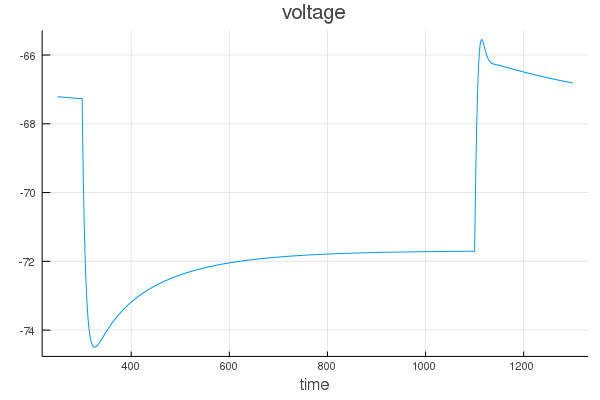

In [5]:
# preview voltage trace
_t_preview = 250.0:0.01:1300.0 # define preview time steps (sampling)
_trace = HHModel.trace_decompose(sol, _model, _t_preview, sim_param);
fig_a = plot(_t_preview, _trace.voltage, 
    legend=nothing, title="voltage", xlabel="time")

---

In [6]:
# running batches of simulations, by using EnsembleProblem.
# Also, you can do this with some loops.
# NOTE: re-using the previous parameters for simplicity

_current_step_protocol = -5.0:1.0:5.0
_prob_update = (prob, i, repeat) -> begin
    _p = (
        E = prob.p.E,
        stim = (start=300, duration=800, step=_current_step_protocol[i], holding=0.0)
    )
    ODEProblem(prob.f, u0, tspan, _p)
end

ensemble_prob = EnsembleProblem(prob, prob_func=_prob_update)
bulk_sim = solve(ensemble_prob,Tsit5(),abstol=1e-7, reltol=1e-7, 
    trajectories=length(_current_step_protocol));

In [7]:
# preview voltage trace
_t_preview = 250.0:0.01:1300.0 # define preview time steps (sampling)
_trace = HHModel.trace_decompose(bulk_sim, _model, _t_preview);

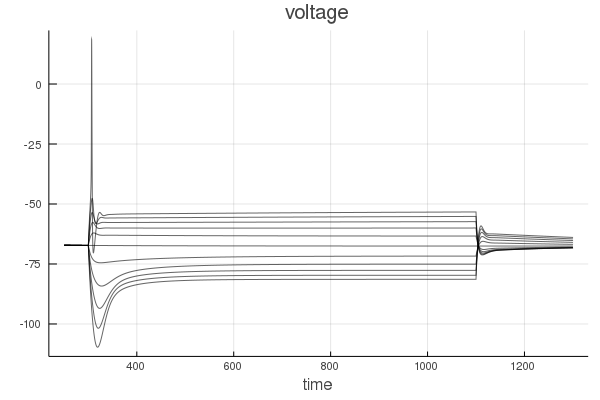

In [8]:
plot(_t_preview, _trace.voltage, color=:black, alpha=0.6)
plot!(legend=nothing, title="voltage", xlabel="time")